In [55]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.transforms import ToPILImage
import torchvision.utils as vutils

from torchcam.methods import LayerCAM, SmoothGradCAMpp
from torchcam.utils import overlay_mask

import clip

import argparse
import os
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image


from tqdm import tqdm
from itertools import cycle

from models.resnet import CustomResNet
from models.projector import ProjectionHead
from domainnet_data import DomainNetDataset, get_domainnet_loaders, get_data_from_saved_files
from utils_proj import SimpleDINOLoss, compute_accuracy, compute_similarities, plot_grad_flow, plot_confusion_matrix
from prompts.FLM import generate_label_mapping_by_frequency, label_mapping_base


to_pil = ToPILImage()


ImportError: cannot import name 'SimpleDINOLoss' from 'utils' (/home/orion/.cache/torch/hub/facebookresearch_dino_main/utils.py)

In [ ]:
def load_image(file_path):
    """
    Load an image and convert it to a NumPy array with values in the range [0, 255].

    Args:
        file_path (str): Path to the image file.

    Returns:
        np.ndarray: Image as a NumPy array with values in the range [0, 255].
    """
    # Open the image file
    image = Image.open(file_path)

    # Convert to RGB mode if not already in RGB
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to NumPy array
    image_array = np.array(image)

    # Ensure values are in the range [0, 255]
    image_array = np.clip(image_array, 0, 255)

    return image_array


In [ ]:

def unnormalize(tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    mean_tensor = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device)
    std_tensor = torch.as_tensor(std, dtype=tensor.dtype, device=tensor.device)
    tensor.mul_(std_tensor[:, None, None]).add_(mean_tensor[:, None, None])
    return tensor

def save_image(tensor, file_name):

    tensor = tensor.detach().cpu()
    # Ensure it's in the range [0, 1]
    tensor = torch.clamp(tensor, 0, 1)

    # Convert to image and save
    vutils.save_image(tensor, file_name)


In [ ]:

# transform = transforms.Compose(
#     [transforms.Resize((224, 224)),
#     # transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                         std=[0.229, 0.224, 0.225])])

CLIP_custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224)
])

Resnet_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
])

def gaussian_noise(x, severity=1):
    c = [0., .08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255


# PIL_image = CLIP_custom_transform(Image.open('./data/domainnet_v1.0/real/toothpaste/real_318_000284.jpg'))

im = load_image('./data/domainnet_v1.0/real/toothpaste/real_318_000284.jpg')
PIL_image = CLIP_custom_transform(Image.fromarray(gaussian_noise(im, severity=1).astype(np.uint8)))

# l = torch.from_numpy(np.array([317]))
# valset = torch.utils.data.TensorDataset(image, l)
# val_loader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False)

In [ ]:
base_dir = f"logs/classifier/resnet50_domainnet_real"
data_dir = f"data/domainnet_v1.0"
prompt_embeddings_pth = "prompts/CLIP_RN50_text_embeddings.pth"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clip_model, preprocess = clip.load("RN50", device=device)

print(preprocess)
clip_model.eval()

# Load class names from a text file
with open(os.path.join(data_dir, 'class_names.txt'), 'r') as f:
    class_names = [line.strip() for line in f.readlines()]
    
loaders, _ = get_domainnet_loaders("real", batch_size=10, data_dir=data_dir)

train_loader = loaders['train']
val_loader = loaders['test']

text_encodings = torch.load(prompt_embeddings_pth)[0]

In [ ]:
# Preprocess the image for clip
image_CLIP = preprocess(PIL_image).unsqueeze(0).to(device)

# Encode the image using CLIP encoder_image
clip_image_features = clip_model.encode_image(image_CLIP)

# Compute similarities between image embeddings and text encodings
orig_similarities_ = compute_similarities(clip_image_features, text_encodings, mode="cosine")
orig_prob_ = F.softmax(orig_similarities_, dim=-1)
orig_predictions_ = torch.argmax(orig_prob_, dim=-1)


print(f"Original Zero-shot prediction: {class_names[orig_predictions_[0].item()]}")

In [ ]:


plt.hist(orig_prob_[0].detach().cpu().numpy(), bins=10)
plt.show()

In [ ]:


# Load your trained model from checkpoint
checkpoint = torch.load('logs/classifier/resnet50_domainnet_real/best_checkpoint.pth')

resnet_model = CustomResNet(model_name='resnet50', num_classes=345, use_pretrained=True)
resnet_model.load_state_dict(checkpoint['model_state_dict'])
resnet_model.eval()
print(f"Loaded model from epoch {checkpoint['epoch']}")
resnet_model.to('cuda')

projector = ProjectionHead(input_dim=2048, output_dim=1024).to('cuda')
projector.load_state_dict(torch.load('logs/classifier/resnet50_domainnet_real/projection_default_prompt_feat_sim0.1_distill1_DN_mapping1_scaled_logits/best_projector_weights.pth'))
projector.eval()


In [ ]:

resnet_images = Resnet_transform(PIL_image).unsqueeze(0).to('cuda')
# Get the ResNet predictions
resnet_logits, resnet_embeddings = resnet_model(resnet_images, return_features=True)
probs_from_resnet = F.softmax(resnet_logits, dim=-1)
resnet_predictions = torch.argmax(probs_from_resnet, dim=-1)

# Project the resnet embeddings
proj_embeddings = projector(resnet_embeddings)
# Compute the predictions using the projected embeddings
similarities = compute_similarities(proj_embeddings, text_encodings, mode="DN")
probs_from_proj = F.softmax(similarities, dim=-1)
proj_predictions = torch.argmax(probs_from_proj, dim=-1)

print(f"ResNet predictions: {class_names[resnet_predictions[0].item()]}")
print(f"Projected predictions: {class_names[proj_predictions[0].item()]}")


In [ ]:
plt.hist(probs_from_resnet[0].detach().cpu().numpy(), bins=10)
plt.show()

In [ ]:
plt.hist(probs_from_proj[0].detach().cpu().numpy(), bins=10)
plt.show()

In [ ]:
clip_image_features_norm = F.normalize(clip_image_features[0], dim=-1)
proj_embeddings_norm = F.normalize(proj_embeddings[0], dim=-1)

clip_text_features_norm = F.normalize(text_encodings[300], dim=-1)

# plt.plot(clip_image_features_norm.detach().cpu().numpy(), label="CLIP")
plt.plot(proj_embeddings_norm.detach().cpu().numpy(), label="Projected")
plt.plot(clip_text_features_norm.detach().cpu().numpy(), label="Text")
plt.legend()
plt.show()

In [ ]:
dataset = DomainNetDataset(root_dir='data/domainnet_v1.0', domain='real', split='train', transform=None)


all_clip_embeddings = []
all_custom_clip_embeddings = []
all_resnet_embeddings = []
all_proj_embeddings = []
for i in range(len(dataset)):
    images, label = dataset[i]

    resnet_images = Resnet_transform(images).unsqueeze(0).to('cuda')
    # Get the ResNet predictions
    resnet_logits, resnet_embeddings = resnet_model(resnet_images, return_features=True)

    # Project the resnet embeddings
    proj_embeddings = projector(resnet_embeddings)
    all_proj_embeddings.append(proj_embeddings.detach().cpu())
    
    # Preprocess the image for clip
    CLIP_images = preprocess(images).unsqueeze(0).to(device)
    clip_image_features = clip_model.encode_image(CLIP_images)
    all_clip_embeddings.append(clip_image_features.detach().cpu())

    custom_CLIP_images = preprocess(CLIP_custom_transform(images)).unsqueeze(0).to(device)
    custom_clip_image_features = clip_model.encode_image(custom_CLIP_images)
    all_custom_clip_embeddings.append(custom_clip_image_features.detach().cpu())


    if i == 100:
        break

all_clip_embeddings = torch.cat(all_clip_embeddings, dim=0)
all_proj_embeddings = torch.cat(all_proj_embeddings, dim=0)
all_custom_clip_embeddings = torch.cat(all_custom_clip_embeddings, dim=0)

In [ ]:
from utils import plot_umap_embeddings

plot_umap_embeddings(all_clip_embeddings, all_proj_embeddings, text_encodings.detach().cpu(), labels=['CLIP image', 'Projected image', 'CLIP Text'])

In [ ]:
from torchvision.datasets import CIFAR100


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

CLIP_model, preprocess = clip.load("RN50", device='cuda')
dataset = CIFAR100(root="./data", download=True, transform=None, train=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32)



In [ ]:
resnet_model = CustomResNet(model_name='resnet50', num_classes=100, use_pretrained=True).to('cuda')

projector_CIFAR100 = ProjectionHead(input_dim=2048, output_dim=1024).to('cuda')
projector_imagenet = ProjectionHead(input_dim=2048, output_dim=1024).to('cuda')

# Load projector weights from checkpoint
projector_CIFAR100.load_state_dict(torch.load('logs/classifier/resnet50_cifar100/projection_default_prompt_DN_mapping1_scaled_logits/best_projector_weights.pth'))
projector_CIFAR100.eval()
projector_imagenet.load_state_dict(torch.load('logs/classifier/imagenet/contrastive_loss/resnet50_imagenet_None/projection_default_prompt_feat_sim0_distill1_cosine_mapping1_scaled_logits/best_projector_weights.pth'))
projector_imagenet.eval()

In [ ]:

all_cifar_100_projections = []
all_imagenet_projections = []
all_clip_embeddings = []

for i in range(len(dataset)):
    images, label = dataset[i]

    resnet_images = transform(images).unsqueeze(0).to('cuda')
    # Get the ResNet predictions
    resnet_logits, resnet_embeddings = resnet_model(resnet_images, return_features=True)

    # Project the resnet embeddings
    proj_embeddings = projector_CIFAR100(resnet_embeddings)
    all_cifar_100_projections.append(proj_embeddings.detach().cpu())

    proj_embeddings = projector_imagenet(resnet_embeddings)
    all_imagenet_projections.append(proj_embeddings.detach().cpu())
    
    # Preprocess the image for clip
    CLIP_images = preprocess(images).unsqueeze(0).to(device)
    clip_image_features = clip_model.encode_image(CLIP_images)
    all_clip_embeddings.append(clip_image_features.detach().cpu())

    if i == 300:
        break

all_cifar_100_projections = torch.cat(all_cifar_100_projections, dim=0).detach().cpu()
all_imagenet_projections = torch.cat(all_imagenet_projections, dim=0).detach().cpu()
all_clip_embeddings = torch.cat(all_clip_embeddings, dim=0).detach().cpu()


In [ ]:
from utils import plot_umap_embeddings

plot_umap_embeddings(all_cifar_100_projections, all_imagenet_projections, all_clip_embeddings, labels=['CIFAR100 Projection', 'Imagenet Projection', 'CLIP Image Encoder'])

In [1]:
from segment_anything import sam_model_registry, SamPredictor
import torch
import cv2
sam = sam_model_registry["vit_h"](checkpoint="checkpoints/sam_vit_h_4b8939.pth").to('cuda')
sam_vit = sam.image_encoder
test_image = torch.randn(1, 3, 1024, 1024).to('cuda')

print(sam.image_encoder.img_size)
print(sam_vit(test_image).shape)

1024


OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 10.75 GiB total capacity; 9.56 GiB already allocated; 70.94 MiB free; 9.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

In [ ]:
image = cv2.imread('./data/domainnet_v1.0/real/toothpaste/real_318_000284.jpg')
predictor.set_image(image)
image_embeddings = predictor.get_image_embedding()
print(image_embeddings.shape)

In [7]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from models.mae import models_mae

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(x, model):

    # x = torch.tensor(img)

    # # make it a batch-like
    # x = x.unsqueeze(dim=0)
    # x = torch.einsum('nhwc->nchw', x)

    # run MAE
    # loss, y, mask = model(x.float(), mask_ratio=0)

    print(x.shape)

    latent, mask, ids_restore = model.forward_encoder(x.float(), mask_ratio=0)
    y = model.forward_decoder(latent, ids_restore)

    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

KeyError: 'models'

In [1]:
from torchvision import transforms

# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
# img = Image.open(requests.get(img_url, stream=True).raw)
img = Image.open('./data/domainnet_v1.0/real/toothpaste/real_318_000284.jpg')
transform = transforms.Compose([
                            transforms.Resize((224,224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])                
                        ])
img = transform(img).unsqueeze(0)

plt.rcParams['figure.figsize'] = [5, 5]
show_image(img[0].permute(1, 2, 0))

NameError: name 'Image' is not defined

In [45]:
chkpt_dir = 'checkpoints/mae_visualize_vit_large_ganloss.pth'
model = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [47]:
latent, mask, ids_restore = model.forward_encoder(img.float(), mask_ratio=0)
print(latent.shape)
y = model.forward_decoder(latent, ids_restore)
y = model.unpatchify(y)

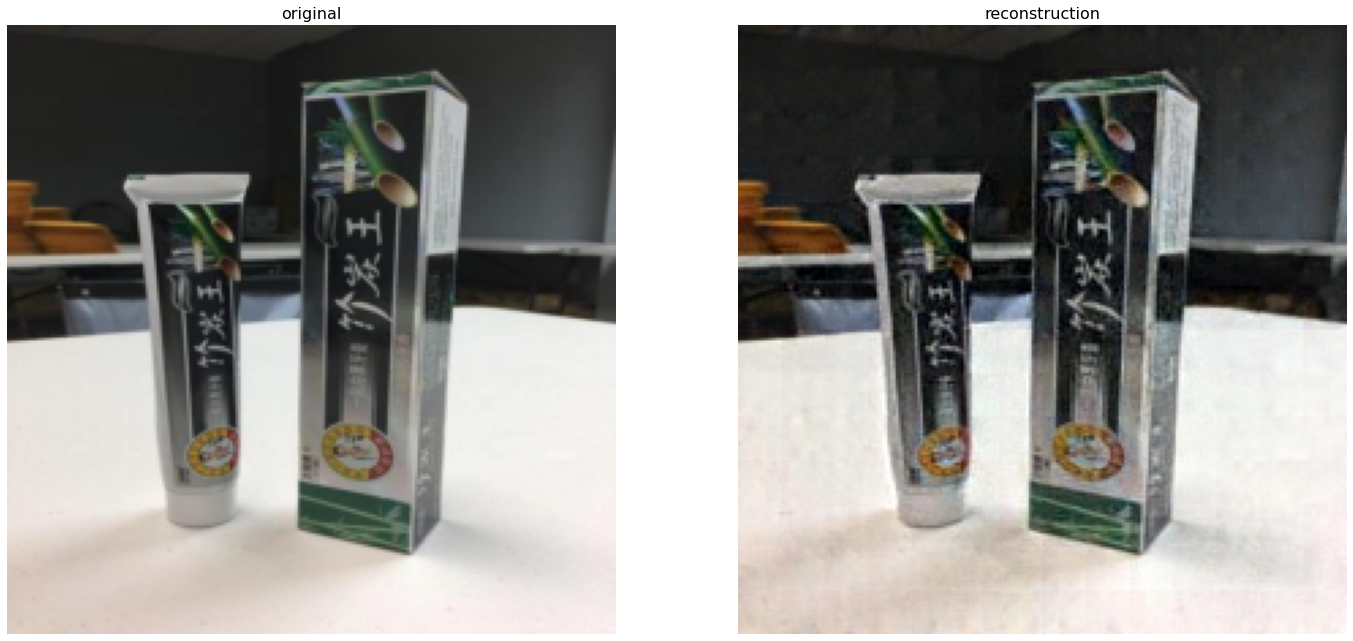

In [49]:
x = torch.einsum('nchw->nhwc', img).detach().cpu()
y = torch.einsum('nchw->nhwc', y).detach().cpu()

# make the plt figure larger
plt.rcParams['figure.figsize'] = [24, 24]

plt.subplot(1, 2, 1)
show_image(x[0], "original")

plt.subplot(1, 2, 2)
show_image(y[0], "reconstruction")

plt.show()

MAE with extra GAN loss:
torch.Size([1, 3, 224, 224])


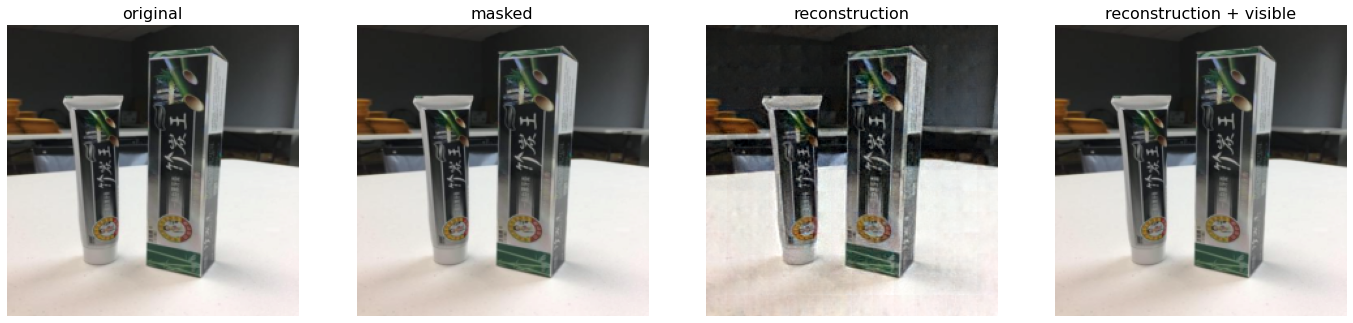

In [43]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model)

In [54]:
import torch

# vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

print(vits16)

Using cache found in /home/orion/.cache/torch/hub/facebookresearch_dino_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)


In [53]:
emb = vits16(torch.randn(1, 3, 224, 224))
print(emb.shape)

torch.Size([1, 384])


In [12]:
from transformers import AutoFeatureExtractor, ViTMAEModel
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/vit-mae-base")
model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(inputs)
# print(inputs)
print(last_hidden_states.shape)

/home/orion/.virtualenvs/pytorch/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/vit-mae-base were not used when initializing ViTMAEModel: ['decoder.decoder_layers.2.attention.output.dense.bias', 'decoder.decoder_layers.6.output.dense.bias', 'decoder.decoder_layers.0.intermediate.dense.weight', 'decoder.decoder_layers.1.output.dense.weight', 'decoder.decoder_layers.2.attention.output.dense.weight', 'decoder.decoder_layers.5.attention.attention.key.weight', 'decoder.decoder_layers.1.layernorm_after.bias', 'decoder.decoder_layers.5.attention.attention.value.bias', 'decoder.decoder_layers.6.attention.attention.query.bias', 'decoder.decoder_layers.0.output.dense.bias', 'decoder.decoder_layers.1.attention.attention.query.weight', 'decoder.decoder_l

{'pixel_values': tensor([[[[ 0.3138,  0.4337,  0.4679,  ..., -0.3541, -0.3369, -0.3369],
          [ 0.3652,  0.4337,  0.4679,  ..., -0.3541, -0.3541, -0.3883],
          [ 0.3138,  0.3994,  0.4166,  ..., -0.4397, -0.4226, -0.4054],
          ...,
          [ 1.8893,  1.7865,  1.6667,  ...,  1.5982,  1.4783,  1.4098],
          [ 1.8722,  1.8037,  1.7523,  ...,  1.3413,  1.0844,  0.9303],
          [ 1.8550,  1.7180,  1.7180,  ...,  0.2282, -0.0458, -0.3541]],

         [[-1.5980, -1.6155, -1.6155,  ..., -1.7906, -1.7906, -1.8081],
          [-1.5630, -1.5630, -1.5630,  ..., -1.7556, -1.7556, -1.7731],
          [-1.6155, -1.5980, -1.5630,  ..., -1.7906, -1.7906, -1.7906],
          ...,
          [-0.4076, -0.5126, -0.6176,  ..., -0.7577, -0.8277, -0.8803],
          [-0.4076, -0.4601, -0.5651,  ..., -0.8803, -1.0203, -1.0903],
          [-0.4251, -0.5651, -0.5826,  ..., -1.4405, -1.5455, -1.6681]],

         [[-0.7936, -0.6193, -0.6541,  ..., -1.2293, -1.1247, -1.1770],
          [-0